In [1]:
import os
import numpy as np
import argparse
import easydict

import dataset
import network
import utils
import audio_utils

import librosa
import librosa.display
import torch
import torchaudio
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline


In [2]:
opt = easydict.EasyDict({
    "data_dir": '/data1/singing_inpainting/dataset',
    "input_length": 220500,
    "image_height": 513,
    "image_width": 431,
    "bbox_shape": 120,
    "num_workers": 4,
    "batch_size": 1,
    "mask_type" : 'time',
    "load_name" : '/data2/personal/jaejun/inpainting/results/210718/time2/models/deepfillv2_WGAN_epoch26_batchsize4.pth',
    "sample_path" : '/data2/personal/jaejun/inpainting/results/210718/time2/validation26',
    "in_channels" : 2,
    "out_channels" : 1,
    "latent_channels" : 32,
    "pad_type": 'zero',
    "activation": 'lrelu',
    "norm": 'in',
    "spec_pow": 2,
    "mask_init": 'lerp',
    "phase": 0,
    })

In [3]:
def db_to_linear(db_input, opt):
    if opt.spec_pow == 2:
        linear_output = torchaudio.functional.DB_to_amplitude(db_input, ref=1.0, power=1)
    elif opt.spec_pow == 1:
        linear_output = torchaudio.functional.DB_to_amplitude(db_input, ref=1.0, power=0.5)
    return linear_output

In [33]:
torch_gflim = torchaudio.transforms.GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512)
custom_gflim = audio_utils.Custom_GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512, power=opt.spec_pow, rand_init='rand')


In [5]:
testset = dataset.InpaintDataset(opt, split='VALID')
print('The overall number of images equals to %d' % len(testset))
dataloader = DataLoader(testset, batch_size = opt.batch_size, pin_memory = True)


The overall number of images equals to 738


In [167]:
idx = 98
audio = testset[idx][0]
img = testset[idx][1]
mask = testset[idx][2]
mask_init = testset[idx][3]
complex_spec = audio_utils.get_spectrogram(audio, power=None, return_complex=1, device=None)
audio.shape, img.shape, mask.shape, mask_init.shape

(torch.Size([1, 220500]),
 torch.Size([1, 1025, 431]),
 torch.Size([1, 1025, 431]),
 torch.Size([1, 1025, 431]))

In [168]:
torch_gf_out = torch_gflim(db_to_linear(img, opt))
custom_gf_out = custom_gflim(db_to_linear(img, opt), complex_spec, mask)

In [169]:
torchaudio.save('samples/sample_' + str(idx) + '_gt.wav', audio, sample_rate=44100)
torchaudio.save('samples/sample_' + str(idx) + '_torch_gflim.wav', torch_gf_out, sample_rate=44100)
torchaudio.save('samples/sample_' + str(idx) + '_custom_gflim.wav', custom_gf_out, sample_rate=44100)


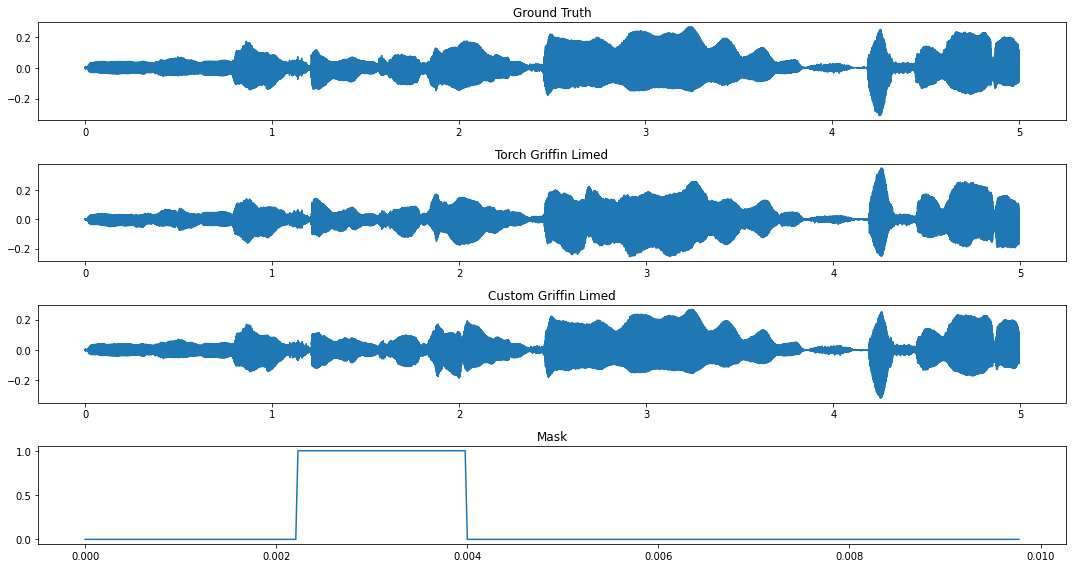

In [170]:
fig = plt.figure(figsize=(15,8))

signal = audio
Time = np.linspace(0, signal.shape[-1] / fs, num=signal.shape[-1])
# plt.plot(Time, signal[0])
ax1 = fig.add_subplot(4, 1, 1)
ax1.set_title('Ground Truth')
ax1.plot(Time, signal[0])

signal = torch_gf_out
Time = np.linspace(0, signal.shape[-1] / fs, num=signal.shape[-1])
# plt.plot(Time, signal[0])
ax2 = fig.add_subplot(4, 1, 2)
ax2.set_title('Torch Griffin Limed')
ax2.plot(Time, signal[0])

signal = custom_gf_out
Time = np.linspace(0, signal.shape[-1] / fs, num=signal.shape[-1])
# plt.plot(Time, signal[0])
ax3 = fig.add_subplot(4, 1, 3)
ax3.set_title('Custom Griffin Limed')
ax3.plot(Time, signal[0])

signal = mask
Time = np.linspace(0, mask.shape[-1] / fs, num=signal.shape[-1])
ax4 = fig.add_subplot(4, 1, 4)
ax4.set_title('Mask')
ax4.plot(Time, mask[0][0])

plt.tight_layout()
plt.savefig('samples/sample_' + str(idx) + '.png')

4.605170185988092